In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rioxarray as rxr
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.features
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import geopandas as gpd
# Rasterstats contains the zonalstatistics function
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

In [15]:
# --- File paths  ---
root_folder = r"/notebooks/ProyectoFinal/Shapes/"
adi_route = root_folder + "/PNNAmacayacu.shp"
adi = gpd.read_file(adi_route).to_crs(epsg=9377)
points_route = root_folder + "/puntos_AGBD4.shp"
points = gpd.read_file(points_route).to_crs(epsg=9377)
stack_route = root_folder + 'imagenes/stack_completo.tif'
stack_route_clip = root_folder + 'imagenes/stack_clip2.tif'
stack = rasterio.open(stack_route)


In [16]:
stack.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 2030,
 'height': 2955,
 'count': 12,
 'crs': CRS.from_epsg(9377),
 'transform': Affine(30.0, 0.0, 5284690.666750421,
        0.0, -30.0, 1222829.6459653839)}

In [17]:
##Extracción de valores del stack con los puntos de entrenamiento y validación

def extract_raster_values_at_points(stack, points):
    all_values = []

    for index, point in points.iterrows():
        x, y = point.geometry.x, point.geometry.y
        row, col = stack.index(x, y)  # Obtener fila y columna

        # Leer TODAS las bandas en esa celda (window)
        pixel_values = stack.read(window=((row, row+1), (col, col+1)))[:, 0, 0]

        all_values.append(pixel_values)

    return all_values

# Aplicar la función
raster_values = extract_raster_values_at_points(stack, points)

# Convertir lista a DataFrame para manejar columnas por banda
import pandas as pd
band_names = [f"band_{i+1}" for i in range(stack.count)]
raster_df = pd.DataFrame(raster_values, columns=band_names)

# Unir con GeoDataFrame
points = points.reset_index(drop=True)
points = points.join(raster_df)

print(points.head())



         AGBD                         geometry  band_1  band_2  band_3  \
0  331.114166   POINT (5335410.59 1194178.726)   140.0     NaN     3.0   
1  138.484665  POINT (5311719.305 1164405.921)   122.0     NaN     3.0   
2  182.734314  POINT (5310310.897 1156957.705)   147.0     NaN     3.0   
3  379.271515  POINT (5307496.616 1154093.557)   141.0     NaN     3.0   
4   95.309685   POINT (5307440.727 1158421.18)   145.0     NaN     3.0   

     band_4    band_5    band_6    band_7    band_8    band_9   band_10  \
0  0.215613  0.084537  0.833677  0.585396 -0.271361  0.029172  0.322349   
1  0.207280  0.078634  0.831464  0.569047 -0.268363  0.027772  0.302231   
2  0.207280  0.078634  0.819978  0.515872 -0.283045  0.027034  0.273628   
3  0.207280  0.078634  0.813804  0.523237 -0.285407  0.028079  0.274901   
4  0.207280  0.078634  0.808717  0.525702 -0.250754  0.029531  0.279898   

    band_11   band_12  
0  0.174085  0.074671  
1  0.166644  0.067354  
2  0.143717  0.058537  
3  0.143

In [18]:
##De gdf a df
points['lon'] = points.geometry.x
points['lat'] = points.geometry.y
df_train = points.drop(columns='geometry').copy()
df_train

,AGBD,band_1,band_2,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,band_11,band_12,lon,lat
0,331.114166,140.0,NaN,3.0,0.215613,0.084537,0.833677,0.585396,-0.271361,0.029172,0.322349,0.174085,0.074671,5.335411e+06,1.194179e+06
1,138.484665,122.0,NaN,3.0,0.207280,0.078634,0.831464,0.569047,-0.268363,0.027772,0.302231,0.166644,0.067354,5.311719e+06,1.164406e+06
2,182.734314,147.0,NaN,3.0,0.207280,0.078634,0.819978,0.515872,-0.283045,0.027034,0.273628,0.143717,0.058537,5.310311e+06,1.156958e+06
3,379.271515,141.0,NaN,3.0,0.207280,0.078634,0.813804,0.523237,-0.285407,0.028079,0.274901,0.143902,0.063333,5.307497e+06,1.154094e+06
4,95.309685,145.0,NaN,3.0,0.207280,0.078634,0.808717,0.525702,-0.250754,0.029531,0.279898,0.159227,0.064521,5.307441e+06,1.158421e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,210.802017,128.0,NaN,3.0,0.207280,0.078634,0.834479,0.549713,-0.299559,0.026157,0.290873,0.147737,0.058700,5.313386e+06,1.162322e+06
5996,219.096085,143.0,NaN,3.0,0.207280,0.078634,0.804923,0.554491,-0.252655,0.032887,0.305310,0.170850,0.072213,5.322442e+06,1.173841e+06
5997,343.000153,140.0,NaN,3.0,0.207280,0.078634,0.832187,0.585190,-0.251935,0.029348,0.321420,0.182120,0.073929,5.321342e+06,1.179975e+06
5998,204.331482,134.0,NaN,3.0,0.207280,0.078634,0.834715,0.573649,-0.275707,0.027956,0.310879,0.166944,0.068719,5.325581e+06,1.182659e+06


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [21]:
### Preparación de datos

random_seed = 42
np.random.seed(random_seed)

X = df_train.iloc[:, 1:13].drop(columns=['band_2'])
X['lon'] = df_train['lon']
X['lat'] = df_train['lat']

y = df_train['AGBD']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=random_seed)
X

,band_1,band_3,band_4,band_5,band_6,band_7,band_8,band_9,band_10,band_11,band_12,lon,lat
0,140.0,3.0,0.215613,0.084537,0.833677,0.585396,-0.271361,0.029172,0.322349,0.174085,0.074671,5.335411e+06,1.194179e+06
1,122.0,3.0,0.207280,0.078634,0.831464,0.569047,-0.268363,0.027772,0.302231,0.166644,0.067354,5.311719e+06,1.164406e+06
2,147.0,3.0,0.207280,0.078634,0.819978,0.515872,-0.283045,0.027034,0.273628,0.143717,0.058537,5.310311e+06,1.156958e+06
3,141.0,3.0,0.207280,0.078634,0.813804,0.523237,-0.285407,0.028079,0.274901,0.143902,0.063333,5.307497e+06,1.154094e+06
4,145.0,3.0,0.207280,0.078634,0.808717,0.525702,-0.250754,0.029531,0.279898,0.159227,0.064521,5.307441e+06,1.158421e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,128.0,3.0,0.207280,0.078634,0.834479,0.549713,-0.299559,0.026157,0.290873,0.147737,0.058700,5.313386e+06,1.162322e+06
5996,143.0,3.0,0.207280,0.078634,0.804923,0.554491,-0.252655,0.032887,0.305310,0.170850,0.072213,5.322442e+06,1.173841e+06
5997,140.0,3.0,0.207280,0.078634,0.832187,0.585190,-0.251935,0.029348,0.321420,0.182120,0.073929,5.321342e+06,1.179975e+06
5998,134.0,3.0,0.207280,0.078634,0.834715,0.573649,-0.275707,0.027956,0.310879,0.166944,0.068719,5.325581e+06,1.182659e+06


In [22]:
##Optimización de hiperparámetros

param_grid = {
    'n_estimators': [300, 500, 750],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=random_seed, n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 750}


In [23]:
# Validación final

y_pred = best_rf.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Validación cruzada
cv_scores = cross_val_score(rf, X, y, cv=10, scoring='r2')
print(f"R² promedio CV: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

R²: 0.26
RMSE: 73.02
MAE: 57.44
R² promedio CV: 0.252 ± 0.033


In [24]:
###Cargar raster multibanda

bands_indices = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Ajusta según tus variables
data_sel = stack.read(indexes=[i+1 for i in bands_indices])  # shape: (n_bandas, filas, cols)

rows, cols = data_sel.shape[1], data_sel.shape[2]

#  Reestructurar datos para predicción

X_all = data_sel.reshape(len(bands_indices), -1).T  # (pixeles, n_bandas)

# Manejo de NaN
X_all = np.where(np.isnan(X_all), 0, X_all)

#Agregar coordenadas (si el modelo las usa)

# Obtener transform del raster para calcular lon/lat
transform = stack.transform
xs = np.arange(cols)
ys = np.arange(rows)
X_coords, Y_coords = np.meshgrid(xs, ys)

# Convertir a coordenadas espaciales
lon, lat = rasterio.transform.xy(transform, Y_coords, X_coords)
lon = np.array(lon).flatten()
lat = np.array(lat).flatten()

# Si tu modelo incluye lon/lat:
X_all = np.column_stack((X_all, lon, lat))

##Predicción con el modelo

y_pred_all = best_rf.predict(X_all)

# Reconstruir a raster

y_pred_raster = y_pred_all.reshape(rows, cols)



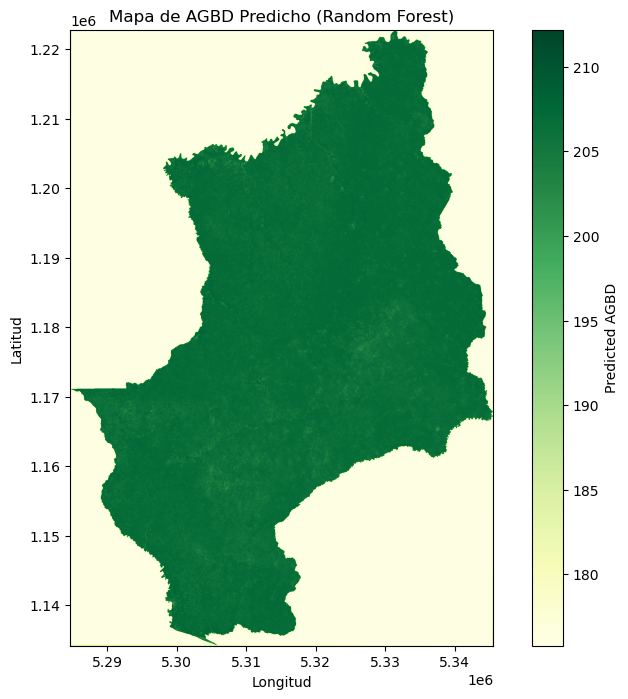

Raster de AGBD guardado en: /notebooks/ProyectoFinal/Shapes/imagenes/AGBD_pred_RF2.tif


In [25]:
#  Visualización rápida

extent = rasterio.plot.plotting_extent(stack)
plt.figure(figsize=(10, 8))
plt.imshow(y_pred_raster, cmap='YlGn', extent=extent)
plt.colorbar(label='Predicted AGBD')
plt.title('Mapa de AGBD Predicho (Random Forest)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

#  Guardar resultado en GeoTIFF

meta = stack.meta.copy()
meta.update({
    "count": 1,
    "dtype": 'float32'
})


out_raster = root_folder + 'imagenes/AGBD_pred_RF2.tif'
with rasterio.open(out_raster, 'w', **meta) as dst:
    dst.write(y_pred_raster.astype(np.float32), 1)

print(f"Raster de AGBD guardado en: {out_raster}") 

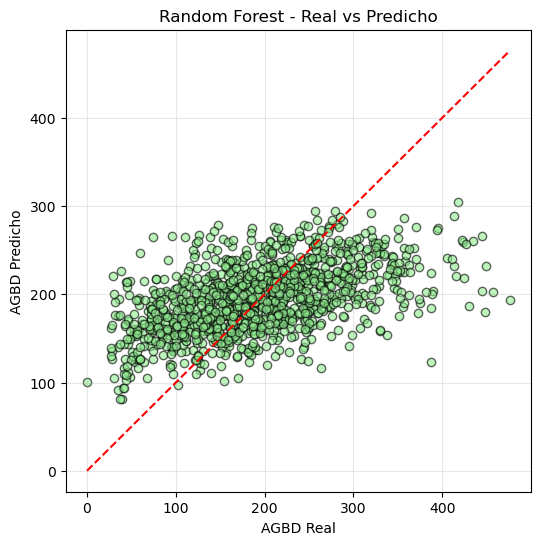

In [26]:
##Gráfico de dispersión

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='lightgreen', edgecolors='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--', color='red')
plt.xlabel('AGBD Real')
plt.ylabel('AGBD Predicho')
plt.title('Random Forest - Real vs Predicho')
plt.grid(alpha=0.3)
plt.show()